# Clustering data using Dhist

Use diagonally cut histogram to model the variability.

Dhist creates a non-uniform histogram which is sampled later to estimate the intercept.

In [3]:
seed=42
df_str=""
metric=""
coeff_col_name=""
coeff_value=0
log=TRUE
xbr_file="/tmp/dhist_xbr.csv"
height_file="/tmp/dhist_height.csv"

We use a special method to create non-uniform histograms to represent the noise in IO operations.

Unable to install the library properly, I copied the important methods here.

Copied from: https://rdrr.io/github/dlebauer/pecan-priors/src/R/plots.R

In [5]:
set.seed(seed) #forcing seed for reproductibility

#' Variable-width (dagonally cut) histogram
#'
#'
#' When constructing a histogram, it is common to make all bars the same width.
#' One could also choose to make them all have the same area.
#' These two options have complementary strengths and weaknesses; the equal-width histogram oversmooths in regions of high density, and is poor at identifying sharp peaks; the equal-area histogram oversmooths in regions of low density, and so does not identify outliers.
#' We describe a compromise approach which avoids both of these defects. We regard the histogram as an exploratory device, rather than as an estimate of a density.
#' @title Diagonally Cut Histogram
#' @param x is a numeric vector (the data)
#' @param a is the scaling factor, default is 5 * IQR
#' @param nbins is the number of bins, default is assigned by the Stuges method
#' @param rx  is the range used for the left of the left-most bin to the right of the right-most bin
#' @param eps used to set artificial bound on min width / max height of bins as described in Denby and Mallows (2009) on page 24.
#' @param xlab is label for the x axis
#' @param plot = TRUE produces the plot, FALSE returns the heights, breaks and counts
#' @param lab.spikes = TRUE labels the \% of data in the spikes
#' @return list with two elements, heights of length n and breaks of length n+1 indicating the heights and break points of the histogram bars.
#' @author Lorraine Denby, Colin Mallows
#' @references Lorraine Denby, Colin Mallows. Journal of Computational and Graphical Statistics. March 1, 2009, 18(1): 21-31. doi:10.1198/jcgs.2009.0002.
dhist<-function(x, a=5*iqr(x),
                 nbins=nclass.Sturges(x), rx = range(x,na.rm = TRUE),
                 eps=.15, xlab = "x", plot = TRUE,lab.spikes = TRUE)
 {

   if(is.character(nbins))
     nbins <- switch(casefold(nbins),
                     sturges = nclass.Sturges(x),
                     fd = nclass.FD(x),
                     scott = nclass.scott(x),
                     stop("Nclass method not recognized"))
   else if(is.function(nbins))
     nbins <- nbins(x)

   x <- sort(x[!is.na(x)])
   if(a == 0)
     a <- diff(range(x))/100000000
   if(a != 0 & a != Inf) {
     n <- length(x)
     h <- (rx[2] + a - rx[1])/nbins
     ybr <- rx[1] + h * (0:nbins)
     yupper <- x + (a * (1:n))/n
                                         # upper and lower corners in the ecdf
     ylower <- yupper - a/n
                                         #
     cmtx <- cbind(cut(yupper, breaks = ybr), cut(yupper, breaks = 
                                 ybr, left.include = TRUE), cut(ylower, breaks = ybr),
                   cut(ylower, breaks = ybr, left.include = TRUE))
     cmtx[1, 3] <- cmtx[1, 4] <- 1
                                         # to replace NAs when default r is used
     cmtx[n, 1] <- cmtx[n, 2] <- nbins
                                         #
                                         #checksum <- apply(cmtx, 1, sum) %% 4
     checksum <- (cmtx[, 1] + cmtx[, 2] + cmtx[, 3] + cmtx[, 4]) %%
     4
                                         # will be 2 for obs. that straddle two bins
     straddlers <- (1:n)[checksum == 2]
                                         # to allow for zero counts
     if(length(straddlers) > 0) {
       counts <- table(c(1:nbins, cmtx[ - straddlers, 1]))
     } else {
       counts <- table(c(1:nbins, cmtx[, 1]))
     }
     counts <- counts - 1
                                         #
     if(length(straddlers) > 0) {
       for(i in straddlers) {
         binno <- cmtx[i, 1]
         theta <- ((yupper[i] - ybr[binno]) * n)/a
         counts[binno - 1] <- counts[binno - 1] + (
                                                   1 - theta)
         counts[binno] <- counts[binno] + theta
       }
     }
     xbr <- ybr
     xbr[-1] <- ybr[-1] - (a * cumsum(counts))/n
     spike<-eps*diff(rx)/nbins
     flag.vec<-c(diff(xbr)<spike,F)
     if ( sum(abs(diff(xbr))<=spike) >1) {
       xbr.new<-xbr
       counts.new<-counts
       diff.xbr<-abs(diff(xbr))
       amt.spike<-diff.xbr[length(diff.xbr)]
       for (i in rev(2:length(diff.xbr))) {
         if (diff.xbr[i-1]<=spike&diff.xbr[i]<=spike&
             !is.na(diff.xbr[i])) {
           amt.spike<-amt.spike+diff.xbr[i-1]
           counts.new[i-1]<-counts.new[i-1]+counts.new[i]
           xbr.new[i]<-NA
           counts.new[i]<-NA
           flag.vec[i-1]<-T
         }
         else amt.spike<-diff.xbr[i-1]
       }
       flag.vec<-flag.vec[!is.na(xbr.new)]
       flag.vec<-flag.vec[-length(flag.vec)]
       counts<-counts.new[!is.na(counts.new)]
       xbr<-xbr.new[!is.na(xbr.new)]

     }
     else flag.vec<-flag.vec[-length(flag.vec)]
     widths <- abs(diff(xbr))
     ## N.B. argument "widths" in barplot must be xbr
     heights <- counts/widths
   }
   bin.size <- length(x)/nbins
   cut.pt <- unique(c(min(x) - abs(min(x))/1000,
                      approx(seq(length(x)), x, (1:(nbins - 1)) * bin.size, rule = 2)$y, max(x)))
   aa <- hist(x, breaks = cut.pt, plot = FALSE, probability = TRUE)
   if(a == Inf) {
     heights <- aa$counts
     xbr <- aa$breaks
   }
   amt.height<-3
   q75<-quantile(heights,.75)
   if (sum(flag.vec)!=0) {
     amt<-max(heights[!flag.vec])
     ylim.height<-amt*amt.height
     ind.h<-flag.vec&heights> ylim.height
     flag.vec[heights<ylim.height*(amt.height-1)/amt.height]<-F
     heights[ind.h] <- ylim.height
   }
   amt.txt<-0
   end.y<-(-10000)
   if(plot) {
     barplot(heights, abs(diff(xbr)), space = 0, density = -1, xlab = 
             xlab, plot = TRUE, xaxt = "n",yaxt='n')
     at <- pretty(xbr)
     axis(1, at = at - xbr[1], labels = as.character(at))
     if (lab.spikes) {
       if (sum(flag.vec)>=1) {
         usr<-par('usr')
         for ( i in seq(length(xbr)-1)) {
           if (!flag.vec[i]) {
             amt.txt<-0
             if (xbr[i]-xbr[1]<end.y) amt.txt<-1
           }
           else {
             amt.txt<-amt.txt+1
             end.y<-xbr[i]-xbr[1]+3*par('cxy')[1]
           }
           if (flag.vec[i]) {
             txt<-paste(' ',format(round(counts[i]/
                                         sum(counts)*100)),'%',sep='')
             par(xpd = TRUE)
             text(xbr[i+1]-xbr[1],ylim.height-par('cxy')[2]*(amt.txt-1),txt, adj=0)
           }}
       }
       else print('no spikes or more than one spike')
     }
     invisible(list(heights = heights, xbr = xbr))
   }
   else {
     return(list(heights = heights, xbr = xbr,counts=counts))
   }
 }

#' Calculate interquartile range
#'
#' Calculates the 25th and 75th quantiles given a vector x; used in function \link{dhist}.
#' @title Interquartile range
#' @param x vector
#' @return numeric vector of length 2, with the 25th and 75th quantiles of input vector x. 
iqr<-function(x){
   return(diff(quantile(x, c(0.25, 0.75), na.rm = TRUE)))
}

## Reading dataframe

In [6]:
df = read.csv(text=df_str)
print(summary(df))
head(df)

       X               op               msg_size     start        
 Min.   :  1130   Length:3500        Min.   :1   Min.   : 0.2003  
 1st Qu.: 82565   Class :character   1st Qu.:2   1st Qu.:14.3932  
 Median :179094   Mode  :character   Median :4   Median :30.8789  
 Mean   :174237                      Mean   :4   Mean   :30.3998  
 3rd Qu.:262094                      3rd Qu.:6   3rd Qu.:45.7296  
 Max.   :358579                      Max.   :7   Max.   :63.0828  
    duration          experiment            type               index       
 Min.   :1.510e-07   Length:3500        Length:3500        Min.   :  2260  
 1st Qu.:1.560e-07   Class :character   Class :character   1st Qu.:165130  
 Median :1.580e-07   Mode  :character   Mode  :character   Median :358189  
 Mean   :2.322e-07                                         Mean   :348475  
 3rd Qu.:2.270e-07                                         3rd Qu.:524188  
 Max.   :1.452e-05                                         Max.   :717158  

,X,op,msg_size,start,duration,experiment,type,index,origin
,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>
1,1130,MPI_Send,3,0.200334,2.57e-07,grenoble,exp/exp_PingPong.csv,2260,real
2,1131,MPI_Send,3,0.200338,1.85e-07,grenoble,exp/exp_PingPong.csv,2262,real
3,1132,MPI_Send,3,0.200342,1.63e-07,grenoble,exp/exp_PingPong.csv,2264,real
4,1133,MPI_Send,3,0.200345,1.56e-07,grenoble,exp/exp_PingPong.csv,2266,real
5,1134,MPI_Send,3,0.200349,1.54e-07,grenoble,exp/exp_PingPong.csv,2268,real
6,1135,MPI_Send,3,0.200352,1.64e-07,grenoble,exp/exp_PingPong.csv,2270,real


## Clustering

Calculating the intercept for the duration of each message.

In [7]:
df$intercept_estimate = df[[metric]] - df[[coeff_col_name]]*coeff_value

Running dhist.

In [55]:
data = df$intercept_estimate
if (log) {
    data = log(data)
}

dh = dhist(data, plot=FALSE)

dh

Warning message in hist.default(x, breaks = cut.pt, plot = FALSE, probability = TRUE):
“argument ‘probability’ is not made use of”


$heights

          1           2           3           4           5           6 
4510.135322 5863.669177 7666.843201 2453.222423 1045.499552  347.102832 
          7           8           9          10          11          12 
1448.764591  211.473846    0.000000    0.000000    0.000000    0.000000 
         13 
   1.778268 

$xbr
 [1] 1.054988e-07 1.210706e-07 1.354500e-07 1.482141e-07 1.828565e-07
 [6] 2.538565e-07 4.000706e-07 5.307136e-07 8.678415e-07 1.523917e-06
[11] 2.675975e-06 4.698973e-06 8.251327e-06 1.447928e-05

$counts

       1        2        3        4        5        6        7        8 
620.9278 658.0722 690.4405 515.2837 342.9944 157.8873 409.3941 104.0000 
       9       10       11       12       13 
  0.0000   0.0000   0.0000   0.0000   1.0000 


Saving result to cvs

In [56]:
write.csv(list(xbr=dh$xbr), xbr_file)
write.csv(dh$heights, height_file)

## Visualizing

Histogram with vertical lines at the mean of each cluster.

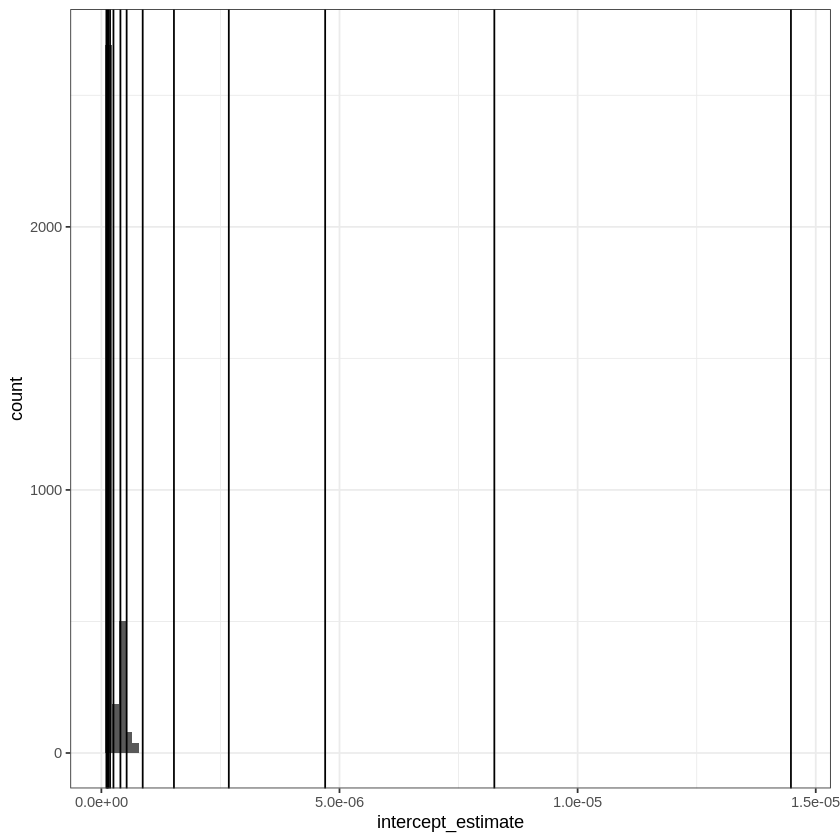

In [58]:
library(ggplot2)

if (log) {
    dh$xbr = exp(dh$xbr)
}

ggplot(df, aes(x=intercept_estimate)) + geom_histogram(bins=100) +
    geom_vline(xintercept=dh$xbr) + 
    theme_bw()

Same but in log scale

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 59 rows containing missing values (geom_bar).”


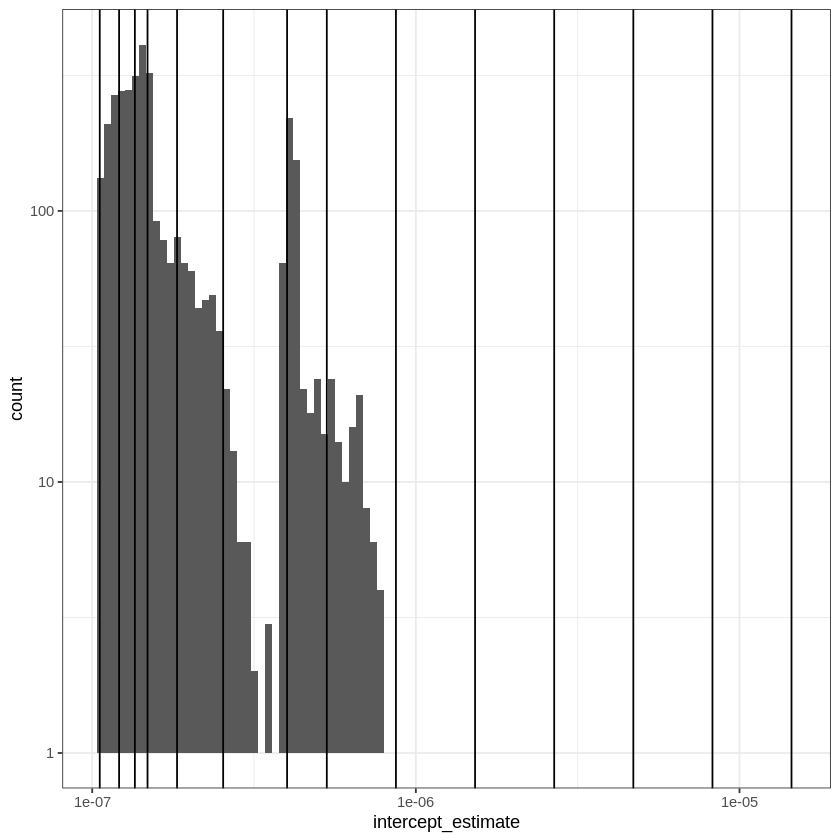

In [59]:
ggplot(df, aes(x=intercept_estimate)) + geom_histogram(bins=100) +
    geom_vline(xintercept=dh$xbr) + 
    scale_x_log10() + scale_y_log10() +
    theme_bw()
ggsave(paste0('plot_dhist_', unique(df$op), '.png'))